In [63]:
#%%capture
%load_ext line_profiler
%matplotlib inline


# Had to install this funcy dependency manually, there was a bug in cadCAD, where the dependency wasn't loaded
# import sys
# !{sys.executable} -m pip install --user funcy

# instal line profiler, for optimizing notebook
# !pip install --user line_profiler


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import importlib
import policies
import config
import state_updates
import utils
from numpy.random import rand

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, disaster_ideal, rarity, market_settings = config.initial_conditions, config.disaster_ideal, config.rarity, config.market_settings

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [64]:
%%time
import os.path
import json

num_runs = 1

def player_active():
    awake_likelihood = 0.6  # 60% probability of player being awake
    active_likelihood = 0.05 # 3 hours of play in 7 day week
    return rand() < (awake_likelihood*active_likelihood)

params = {
    'duration': 60, # duration of timestep (in minutes)
    'player_active': player_active,
    'payMultiplier': 0.2
}

previousRuns = (0) * 24
days = 5
num_timesteps = int(24 * days)
simulation_parameters = {
    'T': range(num_timesteps),
    'N': num_runs,
    'M': params
}


initialized_conditions = initial_conditions
# initialized_conditions = disaster_ideal
        

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    {
        'policies': {},
        'variables': {
            's': state_updates.initialize
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'participantPool': policies.participant_pool_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_participant_pool
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'minerPolicy': policies.miner_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state_miner_policy
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'marketActivityPolicy': policies.market_activity_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    {
        'policies': {},
        'variables':{
            's': state_updates.save_file
        }
    }
    #     speculators # folks speculating on clover coin price
]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initialized_conditions.copy(), #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x7f9c403859b0>]
timestep 0
clovers 0
timestep 1
clovers 12
timestep 2
clovers 23
timestep 3
clovers 41
timestep 4
clovers 53
timestep 5
clovers 87
timestep 6
clovers 108
timestep 7
clovers 136
timestep 8
clovers 147
timestep 9
clovers 158
timestep 10
clovers 186
timestep 11
clovers 197
timestep 12
clovers 214
timestep 13
clovers 233
timestep 14
clovers 260
timestep 15
clovers 271
timestep 16
clovers 290
timestep 17
clovers 311
timestep 18
clovers 330
timestep 19
clovers 341
timestep 20
clovers 352
timestep 21
clovers 364
timestep 22
clovers 392
timestep 23
clovers 403
timestep 24
clovers 435
timestep 25
clovers 460
timestep 26
clovers 501
timestep 27
clovers 528
timestep 28
clovers 561
timestep 29
clovers 586
timestep 30
clovers 637
timestep 31
clovers 673
timestep 32
clovers 707
timestep 33
clovers 734
timestep 34
clovers 767
timestep 35
clovers 792
timestep 36
clovers 818
timestep 37
clovers 851
timestep 38
clovers 887
time

In [65]:
%%time
# {'s': {'bc-balance': 40, 'bc-totalSupply': 30297.222282697643, 'symmetries': {'hasSymmetry': 0, 'rotSym': 0, 'y0Sym': 0, 'x0Sym': 0, 'xySym': 0, 'xnySym': 0}, 'network': <networkx.classes.digraph.DiGraph object at 0x7feb94401eb8>, 'players': [61728968314424, 293889188073290, 226408724277593, 472925374878931, 638758537652366, 344097444779201, 129303744057255, 316855034068104, 215183806154351, 232027941686814], 'miners': [895282972085115], 'bank': 325998228332377, 'clovers': []}}
def to_df(raw_result):
    def flatten_cols(row):
        timestep = row['timestep']
        row['timestep'] += previousRuns
        substep = row['substep']
        run = row['run']
        s = row['s']
        new_cols = {}
        miners = utils.get_nodes_by_type(s, 'miner')
        players = utils.get_nodes_by_type(s, 'player')
        clovers = utils.get_nodes_by_type(s, 'clover')
        sample_clover = {'hasSymmetry': True}
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            sample_clover[key] = False
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            clover = dict(sample_clover)
            clover[key] = True
            reward = utils.getCloverReward(s['symmetries'], clover, market_settings)
            new_cols['reward-' + key] = reward
            cashout = utils.calculateCashout(s, market_settings, reward)
            if (cashout == 0):
                cashout = .001311
            new_cols['reward-eth-' + key] = cashout

        new_cols['cost-to-mine'] = market_settings['register_clover_cost_in_eth']
        new_cols['cost-to-mine-usd'] = market_settings['register_clover_cost_in_eth'] * 300
        new_cols['miners'] = len(miners)
        new_cols['players'] = len(players)
        new_cols['clovers'] = len(clovers)
        new_cols.update(s['symmetries'])
        price = utils.calculateCurrentPrice(s, market_settings)
        if (price == 0):
#             _s = raw_results[(row['timestep'] - 1) * len(partial_state_update_blocks)]
#             price = utils.calculateCurrentPrice(_s, market_settings)
            price = 0.000803
        new_cols['coin-price'] = price
        new_cols['coin-price-usd'] = new_cols['coin-price'] * 300
        # new_cols['playerClovers'] = new_cols['clovers'] = new_cols['bankClovers']
        # for clover_attr in ['hasSymmetry', 'y0Sym', 'x0Sym', 'xySym', 'xnySym', 'rotSym', 'pretty']:
        #     new_cols['net_' + clover_attr] = len([c for c in clovers if g.nodes[c][clover_attr]])

        res = {**row, **s, **new_cols}
        res.pop('network')
#         res.pop('hasSymmetry')
        res.pop('previous-timesteps')
        res.pop('symmetries')
        res.pop('bank')
#         res.pop('miners')
#         res.pop('players')
#         res.pop('clovers')
        res.pop('run')
        res.pop('s')
        return res

    return pd.DataFrame(map(flatten_cols, raw_result))

full_df = to_df(raw_result)
# adding new useful columns for graphing


full_df['market-cap'] = full_df['coin-price'] * full_df['bc-totalSupply'] * 300

full_df

CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 101 ms


In [66]:
_s = raw_result.pop()['s']
# _g = _s['network']
g = utils.getNetwork()
# print(len(g.nodes))
print("clovers", len([node for node in g.nodes if g.nodes[node]['type']== 'clover' ]))
print("miners", len([node for node in g.nodes if g.nodes[node]['type']== 'miner' ]))
print("players", len([node for node in g.nodes if g.nodes[node]['type']== 'player' ]))
def make_clover(cloverId):
    clover = g.node[cloverId]
    clover['_id'] = cloverId
    return clover
clover_df = pd.DataFrame(map(make_clover, _s['clovers']))
pd.set_option('display.max_rows', 50)
# pd.concat([clover_df.head(10), clover_df.tail(10)])
# clover_df

clovers 4568
miners 6
players 35


In [67]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df = full_df[full_df['substep'] == len(partial_state_update_blocks)]
df_with_0 = full_df[full_df['substep'] == 0].append(full_df[full_df['substep'] == len(partial_state_update_blocks)]) # after player policy
df_with_0

,bc-balance,bc-totalSupply,clovers,coin-price,coin-price-usd,cost-to-mine,cost-to-mine-usd,hasSymmetry,miners,players,reward-eth-rotSym,reward-eth-x0Sym,reward-eth-xnySym,reward-eth-xySym,reward-eth-y0Sym,reward-rotSym,reward-x0Sym,reward-xnySym,reward-xySym,reward-y0Sym,rotSym,substep,timestep,x0Sym,xnySym,xySym,y0Sym,market-cap
0,0.000000,0.000000,0,0.000803,0.240900,0.001313,0.3939,1130,0,0,0.001311,0.001311,0.001311,0.001311,0.001311,6.325574,3.188926,0.824487,0.936553,3.162787,60,0,0,120,467,411,121,0.000000
6,31.953501,14275.258669,12,0.001705,0.511561,0.001313,0.3939,1142,1,20,0.010720,0.005317,0.001411,0.001602,0.005404,6.286839,3.118272,0.827567,0.939239,3.168976,61,6,1,124,470,414,122,7302.661792
12,31.932649,14275.258669,23,0.001705,0.511397,0.001313,0.3939,1153,1,20,0.010815,0.005322,0.001418,0.001585,0.005452,6.344855,3.122071,0.831672,0.929979,3.198220,61,6,2,125,472,422,122,7300.317448
18,31.897903,14278.719260,41,0.001704,0.511107,0.001313,0.3939,1171,1,20,0.010971,0.005314,0.001420,0.001586,0.005356,6.439790,3.119273,0.833543,0.930692,3.143835,61,6,3,127,478,428,126,7297.958781
24,31.876374,14278.719260,53,0.001703,0.510938,0.001313,0.3939,1183,1,20,0.011075,0.005323,0.001413,0.001586,0.005407,6.503081,3.125512,0.829611,0.931157,3.174732,61,6,4,128,485,432,126,7295.537777
30,31.855554,14296.224088,87,0.001702,0.510696,0.001313,0.3939,1217,1,20,0.011375,0.005263,0.001399,0.001596,0.005467,6.682403,3.091858,0.822042,0.937351,3.211698,61,6,5,133,503,441,128,7301.019164
36,31.821761,14300.569298,108,0.001701,0.510410,0.001313,0.3939,1238,1,20,0.011187,0.005304,0.001401,0.001595,0.005424,6.575766,3.117400,0.823579,0.937303,3.188250,63,6,6,134,510,448,131,7299.155416
42,31.802201,14327.535224,136,0.001700,0.510136,0.001313,0.3939,1266,1,20,0.010913,0.005260,0.001409,0.001604,0.005298,6.417985,3.093561,0.828526,0.942993,3.115978,66,6,7,138,518,455,137,7308.988043
48,31.781748,14327.535224,147,0.001700,0.509975,0.001313,0.3939,1277,1,20,0.011001,0.005265,0.001409,0.001595,0.005341,6.471672,3.097157,0.829067,0.938532,3.142043,66,6,8,139,522,461,137,7306.681188
54,31.753693,14327.535224,158,0.001699,0.509754,0.001313,0.3939,1288,1,20,0.011087,0.005269,0.001412,0.001591,0.005306,6.525358,3.100702,0.831177,0.936186,3.122850,66,6,9,140,525,466,139,7303.516951


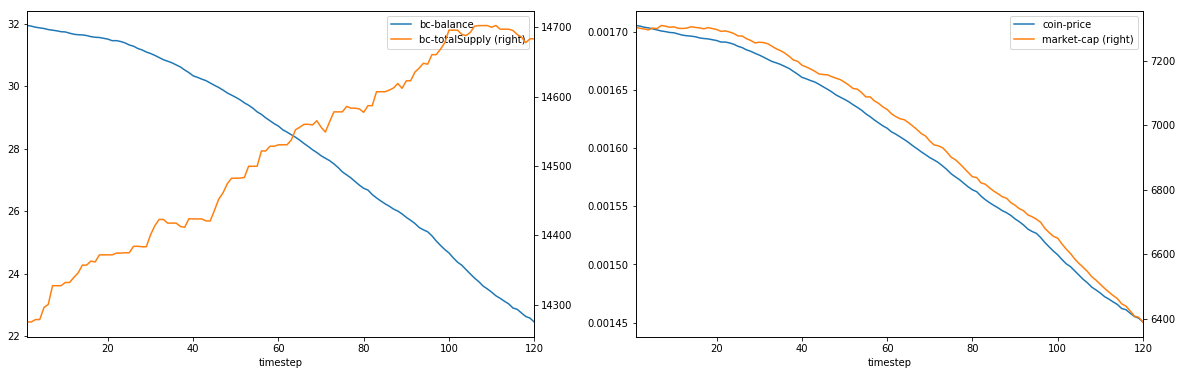

In [68]:
fig = plt.figure(figsize=(20,6*num_runs))
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    df.plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[0])
    df.plot('timestep', ['coin-price', 'market-cap'], secondary_y=['market-cap'], ax=axs[1])
else:
    for run in range(0,num_runs):
        df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[run,0])
        df[df.run == (run+1)].plot('timestep', ['coin-price', 'market-cap'], secondary_y=['market-cap'], ax=axs[run,1])
plt.savefig('from-' + str(previousRuns) + '-to-' + str(previousRuns + num_timesteps) + 'hrs-price-graph.png')

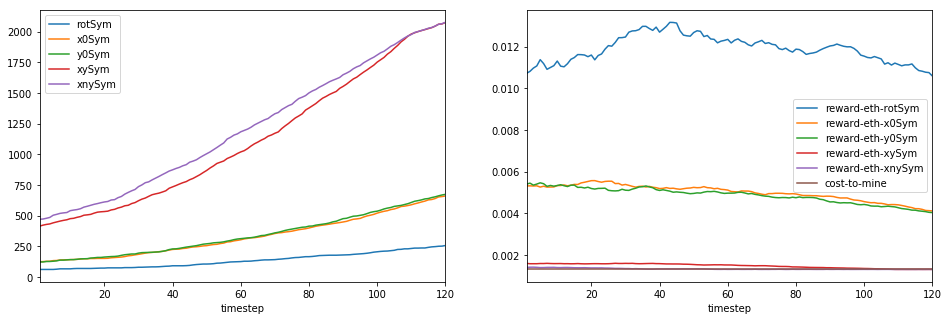

In [69]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
            ax=axs[0]
           )
    
    df.plot('timestep', ['reward-eth-rotSym', 'reward-eth-x0Sym', 'reward-eth-y0Sym', 'reward-eth-xySym', 'reward-eth-xnySym', 'cost-to-mine'], ax=axs[1])

else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', 'bankClovers', ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])
plt.savefig('from-' + str(previousRuns) + '-to-' + str(previousRuns + num_timesteps) + 'hrs-symms-graph.png')

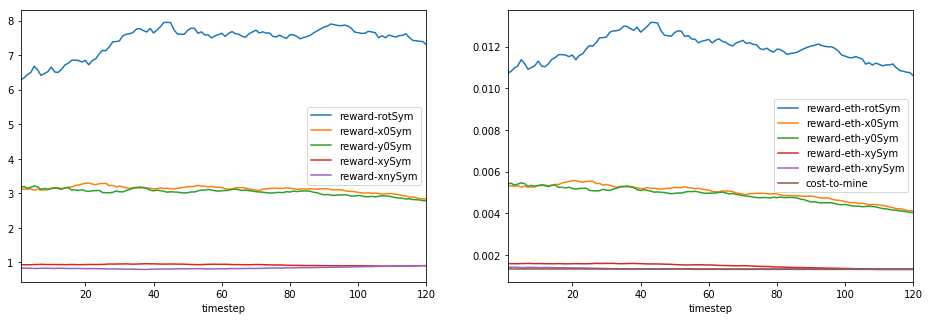

In [70]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', ['reward-eth-rotSym', 'reward-eth-x0Sym', 'reward-eth-y0Sym', 'reward-eth-xySym', 'reward-eth-xnySym', 'cost-to-mine'], ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
#     df.plot('timestep','bankClovers',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', 'clovers', ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
#         df_run.plot('timestep','bankClovers',secondary_y=True, ax=axs[row_idx,1])
plt.savefig('from-' + str(previousRuns) + '-to-' + str(previousRuns + num_timesteps) + 'hrs-reward-graph.png')

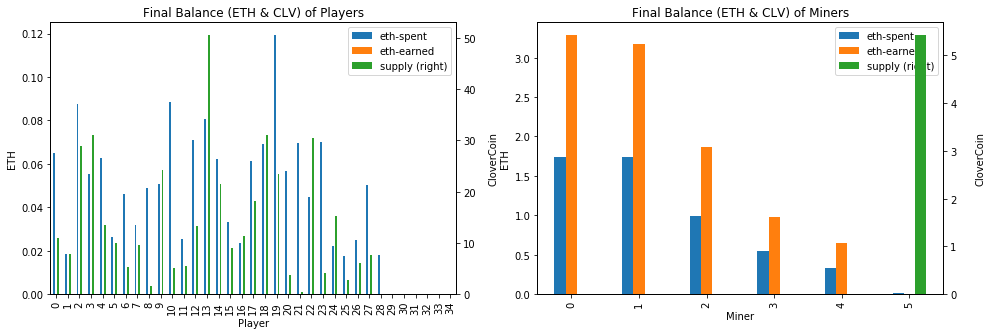

In [71]:
final_state = raw_result[-1]['s']
# g = final_state['network']
g = utils.getNetwork()
miners = utils.get_nodes_by_type(final_state, 'miner')
players = utils.get_nodes_by_type(final_state, 'player')

g.nodes[miners[0]]

cols_to_graph = ['eth-spent', 'eth-earned', 'supply']

fig = plt.figure(figsize=(16,(row_height*num_runs)))
axs = fig.subplots(num_runs, 2)

for row_idx in range(0,num_runs):

    plot_data = [
        {
            "nodes": players,
            "title": "Final Balance (ETH & CLV) of Players",
            "x_label": "Player",
            "axis": (axs[0] if num_runs == 1 else axs[row_idx,0])
        },
        {
            "nodes": miners,
            "title": "Final Balance (ETH & CLV) of Miners",
            "x_label": "Miner",
            "axis": (axs[1] if num_runs == 1 else axs[row_idx,1])
        }
    ]
    
    for plot in plot_data:
        if (len(plot['nodes']) > 0):
            pdf = pd.DataFrame([g.nodes[player] for player in plot['nodes']])
            pdf[['eth-spent', 'eth-earned', 'supply']].plot(kind='bar', ax=plot['axis'], secondary_y='supply')
        plot['axis'].set(xlabel=plot['x_label'], ylabel='ETH', title=plot['title'])
        ax_2y = plot['axis'].twinx()
        ax_2y.set_ylabel("CloverCoin", labelpad=32)
        ax_2y.set_yticks([])
plt.savefig('from-' + str(previousRuns) + '-to-' + str(previousRuns + num_timesteps) + 'hrs-eth-graph.png')

In [72]:
# players = utils.get_nodes_by_type(raw_result[-1]['s'], 'player')
# affinities = np.empty((len(players), num_timesteps))
# # print("affinities", affinities)
# substeps = len(partial_state_update_blocks)
# for i_ind in range(len(players)):
#     nodeId = players[i_ind]
#     for j_ind in range(num_timesteps):
#         g = raw_result[j_ind*substeps]['s']['network']
#         # this line below sets the value to determine the color
#         # for a given player/timestep combination
#         # len(list(g.successors(i_ind))) => owned clovers by this user
#         if g.has_node(nodeId):
#             affinities[i_ind][j_ind] = len(list(g.successors(nodeId)))
#         else:
#             affinities[i_ind][j_ind] = 0

# dims = (20, 8)
# # adjust the dimensions

# fig, ax = plt.subplots(figsize=dims)

# sns.heatmap(affinities,
#             cbar=True, ax=ax)

# plt.title('Clovers owned by player, over time')
# plt.ylabel('Players')
# plt.xlabel('Timestep')
# plt.savefig('from-' + str(previousRuns) + '-to-' + str(previousRuns + num_timesteps) + 'hrs-owners-graph.pdf')

In [73]:
# states = [
#     {"payMultiplier": 0.20, "balance":17.016753, "totalSupply": 14291.312794, "clovers": 9225},
#     {"payMultiplier": 0.21, "balance":14.666017, "totalSupply": 14314.145592, "clovers": 10406},
#     {"payMultiplier": 0.22, "balance":12.515104, "totalSupply": 14327.019669, "clovers": 11401},
#     {"payMultiplier": 0.23, "balance":10.490474, "totalSupply": 14297.158162, "clovers": 12203},
#     {"payMultiplier": 0.24, "balance":8.686000, "totalSupply": 14310.146756, "clovers": 12790},
#     {"payMultiplier": 0.25, "balance":7.028548, "totalSupply": 14314.246525, "clovers": 13336},
#     {"payMultiplier": 0.26, "balance":5.492877, "totalSupply": 14323.500632, "clovers": 13837},
#     {"payMultiplier": 0.27, "balance":5.493877, "totalSupply": 14323.500632, "clovers": 13837},
#     {"payMultiplier": 0.28, "balance":2.726562, "totalSupply": 14323.155641, "clovers": 14343},
#     {"payMultiplier": 0.29, "balance":1.499142, "totalSupply": 14323.301790, "clovers": 14544},
#     {"payMultiplier": 0.30, "balance":0.355566, "totalSupply": 14323.477380, "clovers": 14675},
#     {"payMultiplier": 0.31, "balance":0.000700, "totalSupply": 14382.733430, "clovers": 14218},
#     {"payMultiplier": 0.32, "balance":0.008572, "totalSupply": 20620.749644, "clovers": 17451},
#     {"payMultiplier": 0.325, "balance":0.009267, "totalSupply": 21784.734994, "clovers": 17778},
#     {"payMultiplier": 0.326, "balance":0.005898, "totalSupply": 22876.389313, "clovers": 18401},
#     {"payMultiplier": 0.327, "balance":0.005898, "totalSupply": 22876.389313, "clovers": 18401},
#     {"payMultiplier": 0.33, "balance":0.000397, "totalSupply": 14338.616595, "clovers": 13370},
# ]

# fig = plt.figure(figsize=(16,5))
# axs = fig.subplots(1, 2)
# states = pd.DataFrame(states)
# # draw out all the symmetries in a single graph, on ax1 (the left graph)
# states.plot('payMultiplier', 'clovers', grid=False, ax=axs[0])
# states.plot('payMultiplier', ['balance', 'totalSupply'], secondary_y=['totalSupply'], grid=False, ax=axs[1])

    

In [74]:
# players = utils.get_nodes_by_type(raw_result[-1]['s'], 'player')

# affinities = np.empty((len(players), num_timesteps))
# substeps = len(partial_state_update_blocks)

# for i_ind in range(len(players)):
#     playerId = players[i_ind]
#     for j_ind in range(num_timesteps):
#         g = raw_result[j_ind*substeps]['s']['network']
#         # this line below sets the value to determine the color
#         # for a given player/timestep combination
#         # len(list(g.successors(i_ind))) => owned clovers by this user
#         if g.has_node(playerId):
#             affinities[i_ind][j_ind] = g.nodes[playerId]['is_active']
#         else:
#             affinities[i_ind][j_ind] = False

# dims = (20, 5)

# fig, ax = plt.subplots(figsize=dims)

# sns.heatmap(affinities,
#             cbar=True, ax=ax)

# plt.title('Clovers owned by player, over time')
# plt.ylabel('Players')
# plt.xlabel('Timestep')
# plt.savefig('from-' + str(previousRuns) + '-to-' + str(previousRuns + num_timesteps) + 'hrs-active-graph.pdf')

In [75]:
# def test_function():
#     step = 1
#     s = raw_result[step]

#     _input = policies.miner_policy([params], step, None, s)
#     s['s'] = state_updates.update_state_miner_policy(None, step, None, s, _input)[1]

#     _input = policies.player_policy([params], step, None, s)
#     s['s'] = state_updates.update_state(None, step, None, s, _input)[1]
    
#     _input = policies.market_activity_policy([params], step, None, s)
#     s['s'] = state_updates.update_state(None, step, None, s, _input)[1]
#     return s
# # %lprun -f utils.processBuysAndSells test_function()
# %lprun \
# -f state_updates.update_state_miner_policy \
# -f state_updates.utils.saveNetwork \
# test_function()